# Задача

Напишіть програму для обчислення чутливості і специфічності, а також для побудови ROC-кривої по заданій дискримінантній функції, що розділяє дані про іриси Фішера.


# Рішення

Спочатку імпортуємо залежності


In [25]:
%matplotlib notebook
import csv

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

# змінює стиль графіків зі стандартного, на Bayesian Methods for Hackers
plt.style.use('bmh')

## 1 Завантажимо набір даних

In [6]:
# завантажує csv файл із заданим іменем
def load_csv(file_name):
    with open(file_name, newline='') as csv_file:
        for row in csv.DictReader(csv_file, delimiter=',', quoting=csv.QUOTE_NONNUMERIC):
            yield row

# завантажує файл з даними про іриси Фішера
def load_irises():
    return list(load_csv('iris.csv'))

# змінна із характеристиками ірисів
irises = load_irises()

## 2 Визначимо функцію для знаходження чутливості та специфічності

Аргументи:

* `classifier` — бінарний класифікатор, функція яка буде викликана для кожного рядка із таблиці ірисів; повертає `True` якщо даний ірис належить до цільового виду, інакше `False`
* `classifier_target` — вид ірису, який розпізнає даний класифікатор

Результат: словник з двома елементами
* `sensitivity` — чутливіть (true positive rate) класифікатора
* `specificity` — специфічність (true negative rate) класифікатора

In [16]:
def eval_classifier(classifier, threshold, classifier_target):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    for iris in irises:
        belongs_to_target = classifier(iris, threshold)
        if iris['species'] == classifier_target:
            # (1) ірис належить до виду які класифікатор розпізнає
            if belongs_to_target:
                true_positives += 1
            else:
                false_negatives += 1
        else:
            # (2) іриси інших видів
            if belongs_to_target:
                false_positives += 1
            else:
                true_negatives += 1
    
    # чутливість (true positive rate, tpr)
    sensitivity = true_positives / (true_positives + false_negatives)
    
    # специфічність (true negative rate, tnr)
    specificity = true_negatives / (true_negatives + false_positives)

    return dict(sensitivity=sensitivity, specificity=specificity)

## 3 Визначимо функцію для побудови ROC-кривої

In [46]:
def plot_roc_curve(classifier, classifier_target):
    # аналізуємо класифікатор
    false_positive_rates = [] # 1 - специфічність
    true_positive_rates = [] # чутливість

    for threshold in range(0, 101, 1):
        classifier_quality = eval_classifier(classifier, threshold/100, classifier_target)

        false_positive_rates.append(1 - classifier_quality['specificity']) # fpr = 1 - tnr
        true_positive_rates.append(classifier_quality['sensitivity'])
    
    # будуємо графік
    fig = Figure()
    FigureCanvas(fig)

    ax = fig.add_subplot(111)
    ax.set_title('Receiver Operating Characteristic')
    ax.set_xlabel('False Positive Rate (1 - specificity)')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylabel('True Positive Rate (sensitivity)')
    ax.set_ylim([-0.05, 1.05])
    ax.plot([0, 1], [0, 1], '--', linewidth=1, c='red', alpha=0.5) # the coin-toss line

    ax.plot(false_positive_rates, true_positive_rates, c='dodgerblue')
    ax.plot(false_positive_rates, true_positive_rates, 'o', c='dodgerblue', alpha=0.4)

    return fig

# Приклади

Для прикладу розглянемо два класифікатори для виду _setosa_:

1. `ideal_setosa_classifier` — ідеальний класифікатор
2. `sample_setosa_classifier` — класифікатор, що базується на дискримінантній функції для виду _setosa_ із розділу _«5.3 Классификация цветов ириса»_ в книзі Боровіков В.П. _«Популярное введение в программу STATISTICA»_

## Ідеальний класифікатор

Ідеальний класифікатор має значення _чутливості_ та _специфічності_ рівні 1 при усіх порогових значеннях (threshold).

In [19]:
def ideal_setosa_classifier(iris, threshold):
    return iris['species'] == 'setosa'

In [20]:
for threshold in range(0, 120, 20):
    print("поріг={}, результат: {}".format(threshold, eval_classifier(ideal_setosa_classifier, threshold/100, 'setosa')))

поріг=0, результат: {'sensitivity': 1.0, 'specificity': 1.0}
поріг=20, результат: {'sensitivity': 1.0, 'specificity': 1.0}
поріг=40, результат: {'sensitivity': 1.0, 'specificity': 1.0}
поріг=60, результат: {'sensitivity': 1.0, 'specificity': 1.0}
поріг=80, результат: {'sensitivity': 1.0, 'specificity': 1.0}
поріг=100, результат: {'sensitivity': 1.0, 'specificity': 1.0}


Через це, ROC-крива збігається в точку ідеальної класифікації з _False Positive Rate_ рівним `0` та _True Positive Rate_ `1.0`

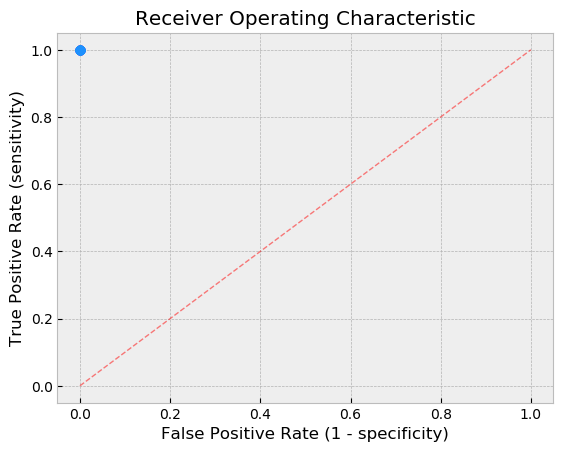

In [47]:
plot_roc_curve(ideal_setosa_classifier, 'setosa')

## Класифікатор-приклад

In [41]:
def sample_setosa_classifier(iris, threshold):
    max_score = 125

    setosa_score = (iris['sepal_length'] + 30 * iris['sepal_width'] - 19 * iris['petal_length'] + 30 * iris['petal_width']) / max_score

    return setosa_score > threshold

Цей класифікатор не ідеальний і його _чутливість_ та _специфічність_ в противазі: із збільшенням порогу, _чутливість_ падає, а _специфічність_ навпаки зростає.

In [51]:
for threshold in range(0, 120, 20):
    print("поріг={}, результат: {}".format(threshold, eval_classifier(sample_setosa_classifier, threshold/100, 'setosa')))

поріг=0, результат: {'sensitivity': 1.0, 'specificity': 0.0}
поріг=20, результат: {'sensitivity': 1.0, 'specificity': 0.04}
поріг=40, результат: {'sensitivity': 1.0, 'specificity': 0.48}
поріг=60, результат: {'sensitivity': 0.86, 'specificity': 1.0}
поріг=80, результат: {'sensitivity': 0.12, 'specificity': 1.0}
поріг=100, результат: {'sensitivity': 0.0, 'specificity': 1.0}


ROC-крива даного класифікатора не ідеальна.

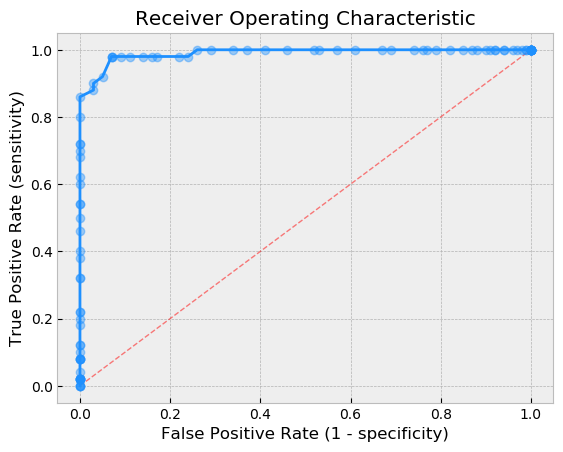

In [48]:
plot_roc_curve(sample_setosa_classifier, 'setosa')

# Додатково

Візуалізація оцінок належності до виду _I. setosa_ використовуючи функцію `sample_setosa_classifier`

<IPython.core.display.Javascript object>


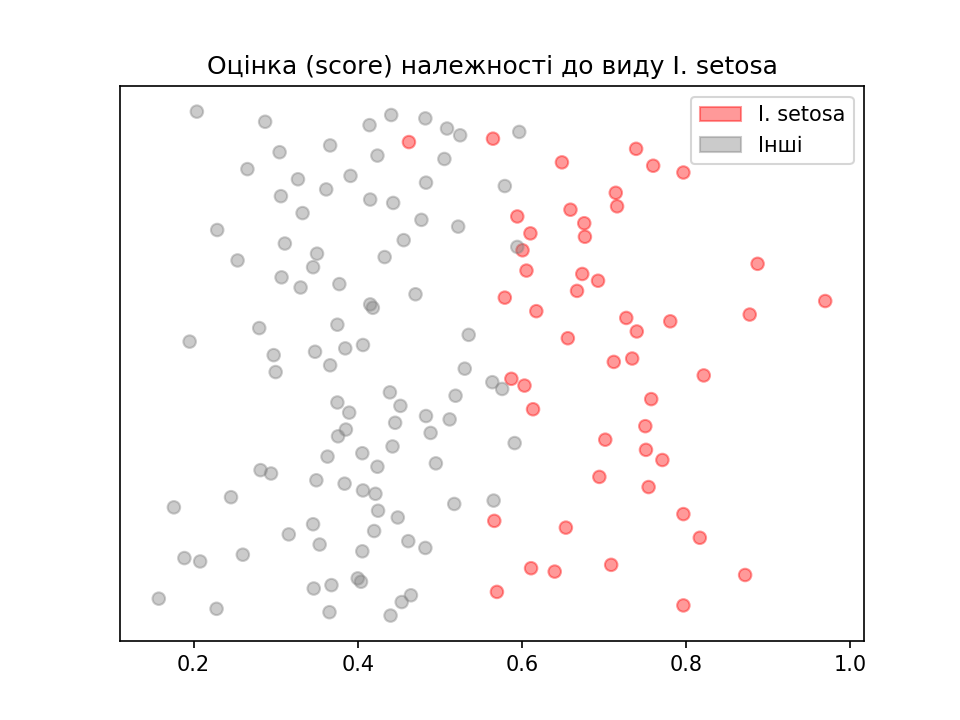

In [24]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

max_score = 125

setosa_scores = [
    (iris['sepal_length'] + 30 * iris['sepal_width'] - 19 * iris['petal_length'] + 30 * iris['petal_width']) / max_score
    for iris in irises
]
ids = [i for i in range(0, 150)]
random.shuffle(ids)

colors = dict(setosa = '#ff000066', versicolor = '#7f7f7f66', virginica = '#7f7f7f66')
color_map = [colors[iris['species']] for iris in irises]

fig, ax = plt.subplots()
plt.title('Оцінка (score) належності до виду I. setosa')
plt.gca().get_yaxis().set_visible(False)
plt.scatter(setosa_scores, ids, c=color_map)

ax.legend(handles = [
    mpatches.Patch(color=colors['setosa'], label='I. setosa'),
    mpatches.Patch(color=colors['virginica'], label='Інші')])
plt.show()

# Посилання

* [ROC Curve and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo)
* [Understanding ROC curves](http://www.navan.name/roc/)
* [Anaconda](https://www.anaconda.com/)
* [Клюшин Д.А. — Розпізнавання образів](http://om.univ.kiev.ua/ua/user-15/Pattern)
* [Розпізнавання образів — Робоча програма](http://csc.knu.ua/media/filer_public/04/58/04580a27-d720-417c-b907-cf42f7719090/m_rozp_obr_primat_1_2.pdf)


* [`iris.csv`](iris.csv)
* [Код програми окремим файлом](lab1.py)